# 🕵️‍♂️ Knowledge Graph Generator from Audit Trails
This notebook extracts triples from audit logs or event text and builds a knowledge graph using RDFLib and NetworkX.
- Input: CSV with event/action logs
- Output: RDF Graph + visualization
- Tools: RDFLib, NetworkX, Pandas, Gradio

In [ ]:
# ✅ Install dependencies
!pip install rdflib networkx pandas matplotlib gradio

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 565.1/565.1 kB 5.7 MB/s eta 0:00:00


In [ ]:
# 📦 Imports
import pandas as pd
import rdflib
import networkx as nx
import matplotlib.pyplot as plt
from rdflib import Graph, URIRef, Namespace
import gradio as gr
import io

In [ ]:
# import google colab
from google.colab import files
uploaded = files.upload()

# Load CSV manually
import pandas as pd
df = pd.read_csv(next(iter(uploaded)))
df.head()


Saving sample_audit_log.csv to sample_audit_log.csv


,timestamp,user,action,object_type,object_id
0,2025-06-01 08:32:10,jdoe,viewed invoice #3421,invoice,3421
1,2025-06-01 08:35:20,asmith,updated contract #881,contract,881
2,2025-06-01 09:10:45,jdoe,deleted file 'Q1_summary.pdf',file,Q1_summary.pdf
3,2025-06-01 09:45:00,mlewis,approved payment #P113,payment,P113
4,2025-06-01 10:15:12,asmith,viewed invoice #3421,invoice,3421


In [ ]:
# google colab
# 🧠 Function: Build RDF Graph + Visualize
def build_kg(file):
    df = pd.read_csv(file.name)

    # Ensure required columns are present
    required_cols = {'Actor', 'Action', 'Target'}
    if not required_cols.issubset(set(df.columns)):
        return "❌ CSV must contain: Actor, Action, Target columns"

    g = Graph()
    NS = Namespace("http://example.org/audit/")

    for _, row in df.iterrows():
        s = URIRef(NS[row['Actor'].replace(" ", "_")])
        p = URIRef(NS[row['Action'].replace(" ", "_")])
        o = URIRef(NS[row['Target'].replace(" ", "_")])
        g.add((s, p, o))

    # 🔁 Convert RDF to NetworkX
    nxg = nx.DiGraph()
    for s, p, o in g:
        s_label = s.split("/")[-1]
        p_label = p.split("/")[-1]
        o_label = o.split("/")[-1]
        nxg.add_edge(s_label, o_label, label=p_label)

    # 🎨 Draw
    pos = nx.spring_layout(nxg, seed=42)
    plt.figure(figsize=(10, 6))
    nx.draw(nxg, pos, with_labels=True, node_color='skyblue', node_size=1500, font_size=10)
    edge_labels = nx.get_edge_attributes(nxg, 'label')
    nx.draw_networkx_edge_labels(nxg, pos, edge_labels=edge_labels, font_color='gray')
    plt.title("🕵️ Knowledge Graph from Audit Trail")
    plt.axis("off")

    # Save and return image path
    output_path = "kg_audit.png"
    plt.savefig(output_path, bbox_inches="tight")
    return output_path

# 🖼️ Gradio UI
gr.Interface(
    fn=build_kg,
    inputs=gr.File(label="Upload Audit Log CSV (columns: Actor, Action, Target)"),
    outputs=gr.Image(type="filepath", label="Knowledge Graph"),
    title="🕵️‍♂️ Knowledge Graph Generator from Audit Trails",
    description="Upload a CSV with columns Actor, Action, and Target to generate a visual RDF-based graph."
).launch()

It looks like you are running Gradio on a hosted a Jupyter notebook. For the Gradio app to work, sharing must be enabled. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://a295ae8dfad6e88bdb.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


# Upload your graph file(s)
##    ▸ Option A: a single .graphml or .gml file
##    ▸ Option B: neo4j_nodes.csv + neo4j_edges.csv pair

In [ ]:
# Install graph-visualization libraries (Colab friendly)
!pip -q install networkx pyvis matplotlib

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 756.0/756.0 kB 12.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 44.4 MB/s eta 0:00:00


In [ ]:
# Upload graph file(s)
from google.colab import files
uploaded = files.upload()          # choose audit_kg.graphml, audit_kg.gml, or the CSVs

Saving audit_kg.graphml to audit_kg.graphml


In [ ]:
# Identify which file(s) were uploaded
graphml_file = next((f for f in uploaded if f.endswith(".graphml")), None)
gml_file     = next((f for f in uploaded if f.endswith(".gml")), None)
nodes_csv    = next((f for f in uploaded if f == "neo4j_nodes.csv"), None)
edges_csv    = next((f for f in uploaded if f == "neo4j_edges.csv"), None)

In [ ]:
# Build a NetworkX graph from whichever input we have
import networkx as nx
import pandas as pd

if graphml_file:
    G = nx.read_graphml(graphml_file)
elif gml_file:
    G = nx.read_gml(gml_file)
elif nodes_csv and edges_csv:
    nodes_df = pd.read_csv(nodes_csv)
    edges_df = pd.read_csv(edges_csv)
    G = nx.DiGraph()
    for _, r in nodes_df.iterrows():
        G.add_node(r["id"], label=r.get("label", r["id"]))
    for _, r in edges_df.iterrows():
        G.add_edge(r["source"], r["target"], label=r.get("label", "edge"))
else:
    raise ValueError("❌ No supported graph files uploaded!")

print(f"Loaded graph with {G.number_of_nodes()} nodes and {G.number_of_edges()} edges.")

Loaded graph with 8 nodes and 6 edges.


In [ ]:
# Interactive visualization with PyVis
from pyvis.network import Network
net = Network(height="600px", width="100%", directed=True, notebook=True)
net.from_nx(G)
net.show("graph.html")

# Display inline in Colab
import IPython, os
IPython.display.IFrame(src="graph.html", width="100%", height="650px")

graph.html


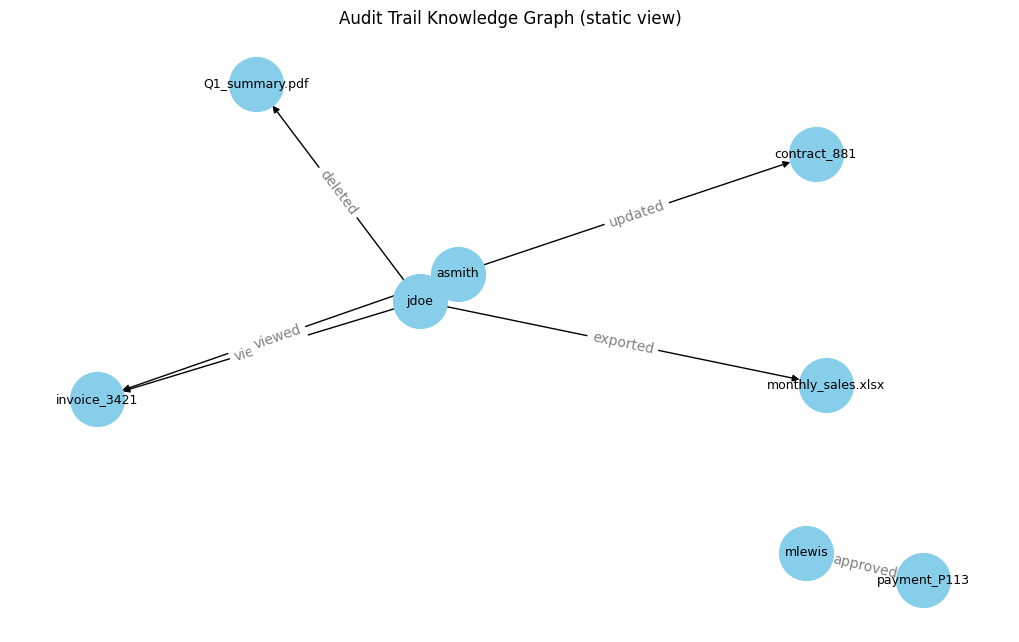

In [ ]:
# Quick static spring-layout via matplotlib
import matplotlib.pyplot as plt

plt.figure(figsize=(10,6))
pos = nx.spring_layout(G, seed=42)
nx.draw(G, pos, with_labels=True, node_color='skyblue', node_size=1500, font_size=9)
edge_labels = nx.get_edge_attributes(G, 'label')
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_color='gray')
plt.title("Audit Trail Knowledge Graph (static view)")
plt.axis("off")
plt.show()

In [ ]:
# 🧠 Convert CSV events to RDF knowledge graph
def build_kg(file):
    df = pd.read_csv(file.name)
    required_cols = {'Actor', 'Action', 'Target'}
    if not required_cols.issubset(set(df.columns)):
        return "CSV must contain: Actor, Action, Target columns"

    g = Graph()
    NS = Namespace("http://example.org/audit/")

    for _, row in df.iterrows():
        s = URIRef(NS[row['Actor'].replace(" ", "_")])
        p = URIRef(NS[row['Action'].replace(" ", "_")])
        o = URIRef(NS[row['Target'].replace(" ", "_")])
        g.add((s, p, o))

    # Visualize with NetworkX
    nxg = nx.DiGraph()
    for s, p, o in g:
        nxg.add_edge(s.split('/')[-1], o.split('/')[-1], label=p.split('/')[-1])

    pos = nx.spring_layout(nxg)
    plt.figure(figsize=(10, 6))
    nx.draw(nxg, pos, with_labels=True, node_color='skyblue', node_size=1500, font_size=10)
    edge_labels = nx.get_edge_attributes(nxg, 'label')
    nx.draw_networkx_edge_labels(nxg, pos, edge_labels=edge_labels)
    plt.title("Audit Trail Knowledge Graph")
    plt.savefig("kg_audit.png")
    return "kg_audit.png"

In [ ]:
# 🎛️ Gradio UI
gr.Interface(
    fn=build_kg,
    inputs=gr.File(label="Upload Audit Trail CSV (Actor, Action, Target)"),
    outputs=gr.Image(label="Knowledge Graph Visualization"),
    title="🕵️‍♂️ Audit Trail Knowledge Graph",
    description="Upload event/action logs and visualize interactions as a knowledge graph"
).launch()